In [354]:
import torch
import torchvision

import os
import cv2
import numpy as np
from PIL import Image
import skimage
import random

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import models

from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import OrderedDict
from IPython.display import clear_output
device="cpu"

In [17]:
%pip install torchgeometry

from torchgeometry.losses import ssim



     -------------------------------------- 42.7/42.7 kB 691.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
class CompLoss(nn.Module):
    def __init__(self):
        super(CompLoss, self).__init__()
        self.BCELoss = torch.nn.BCELoss(reduction="sum")

    def forward(self, pred, target):
        return self.BCELoss(pred, target) + ssim(pred, target, 15, "sum")

In [321]:
class SoRa(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, reg_coef=0.2):
        super(SoRa, self).__init__()
        self.reg_coef = reg_coef
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.fc_layer = nn.Linear(in_channels, out_channels, bias=bias)
        self.sora_mode = False
        self.W1 = None
        self.W2 = None
        self.g = None

    def activate(self, max_rank):
        self.sora_mode = True
        self.W1 = nn.Linear(self.in_channels, max_rank, bias=False)
        self.W2 = nn.Linear(max_rank, self.out_channels, bias=False)
        self.W2.weight = torch.nn.Parameter(torch.zeros_like(self.W2.weight), requires_grad=True)
        self.g = torch.nn.Parameter(torch.ones(max_rank), requires_grad=True)
        self.fc_layer.weight.requires_grad = False

    def forward(self, x):
        res = self.fc_layer(x)
        if self.sora_mode:
            res += self.W2(self.g * self.W1(x))
        return res
    
    def gate(self, lr):
        assert self.sora_mode == True
        self.g.data =  torch.sgn(self.g) * torch.clamp(torch.abs(self.g) - lr * self.reg_coef, min=0)

    def freeze(self):
        assert self.sora_mode == True
        self.g.detach()
        self.W2.weight.detach()
        self.W1.weight.detach()
        self.fc_layer.weight = torch.nn.Parameter(self.fc_layer.weight + (self.g * self.W2.weight) @ self.W1.weight)
        self.sora_mode = False
        self.W1 = None
        self.W2 = None
        self.g = None


class UNet(nn.Module):

    def __init__(self, reg_coef=0.2):
        super(UNet, self).__init__()

        features = 4
        self.encoder1 = UNet._block(3, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder5 = UNet._block(features * 8, features * 8, name="enc5")
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.sora_modules = [SoRa(2048, 2048, bias=True, reg_coef=reg_coef)]
        self.flat = nn.Flatten()
        self.bottleneck = nn.Sequential(OrderedDict([("bottleneckfc", self.sora_modules[0]), ("bottleneckrelu", nn.ReLU())]))

        self.unflat = nn.Unflatten(1, (32, 8, 8))

        self.upconv5 = nn.ConvTranspose2d(
            features * 8, features * 8, kernel_size=2, stride=2
        )
        self.decoder5 = UNet._block((features * 8) * 2, features * 8, name="dec5")

        self.upconv4 = nn.ConvTranspose2d(
            features * 8, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=1, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        enc5 = self.encoder5(self.pool4(enc4))

        bottleneck = self.flat(self.pool5(enc5))

        bottleneck = self.bottleneck(bottleneck)

        bottleneck = self.unflat(bottleneck)

        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((dec5, enc5), dim=1)
        dec5 = self.decoder5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [331]:
module = SoRa(16, 5)
module.activate(3)

optimizer = torch.optim.Adam(module.parameters(), lr=0.01)


In [332]:
X = torch.rand(10, 16)
y = torch.rand(10, 5)

loss_val = []

for i in range(10000):
    optimizer.zero_grad()
    y_pred = module(X)
    loss = nn.MSELoss()(y_pred, y)
    loss_val.append(loss.item())
    loss.backward()
    optimizer.step()
    module.gate(0.01)

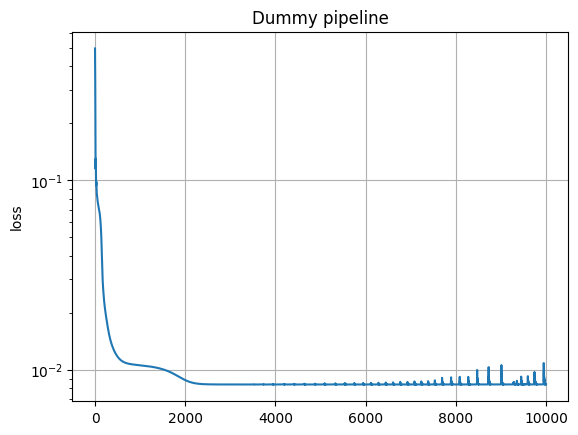

In [334]:
plt.yscale("log")
plt.title("Dummy pipeline")
plt.grid()
plt.ylabel("loss")
plt.plot(loss_val)
plt.show()

In [325]:
module(X)

tensor([[0.5981, 0.7766, 0.2065, 0.1554, 0.7325],
        [0.6586, 0.6685, 0.1614, 0.7389, 0.1726],
        [0.2894, 0.5591, 0.5304, 0.5811, 0.7881],
        [0.6553, 0.6053, 0.2582, 0.7535, 0.3847],
        [0.8763, 0.7554, 0.5593, 0.3691, 0.4997],
        [0.5820, 0.8733, 0.3946, 0.2169, 0.7690],
        [0.9522, 0.6310, 0.2407, 0.3983, 0.5886],
        [0.3508, 0.6578, 0.3238, 0.0069, 0.8933],
        [0.7692, 0.6773, 0.2810, 0.4812, 0.4336],
        [0.2747, 0.6326, 0.2690, 0.8459, 0.3697]], grad_fn=<AddBackward0>)

In [326]:
module.freeze()
module(X)

tensor([[0.5981, 0.7766, 0.2065, 0.1554, 0.7325],
        [0.6586, 0.6685, 0.1614, 0.7389, 0.1726],
        [0.2894, 0.5591, 0.5304, 0.5811, 0.7881],
        [0.6553, 0.6053, 0.2582, 0.7535, 0.3847],
        [0.8763, 0.7554, 0.5593, 0.3691, 0.4997],
        [0.5820, 0.8733, 0.3946, 0.2169, 0.7690],
        [0.9522, 0.6310, 0.2407, 0.3983, 0.5886],
        [0.3508, 0.6578, 0.3238, 0.0069, 0.8933],
        [0.7692, 0.6773, 0.2810, 0.4812, 0.4336],
        [0.2747, 0.6326, 0.2690, 0.8459, 0.3697]], grad_fn=<AddmmBackward0>)

In [327]:
module.fc_layer.weight

Parameter containing:
tensor([[-0.0945, -0.2341,  0.2191, -0.1530,  0.0606, -0.0108, -0.2642, -0.0466,
         -0.2074,  0.0884, -0.0040, -0.1146,  0.4041, -0.0510, -0.0449, -0.1117],
        [ 0.0230,  0.0837,  0.0958,  0.1381, -0.0727, -0.0165, -0.2493, -0.1397,
         -0.0388, -0.1085,  0.0245, -0.0086, -0.0217, -0.1767,  0.0273, -0.0026],
        [-0.0604,  0.1126, -0.0632,  0.0581,  0.0017, -0.0167, -0.2522,  0.1690,
          0.0593,  0.0275, -0.1619,  0.1629,  0.0884,  0.2157, -0.1065,  0.0940],
        [-0.0031,  0.1337, -0.3348, -0.0265,  0.3369,  0.1785,  0.3800, -0.1285,
          0.5232,  0.3639,  0.2234,  0.3893,  0.1388,  0.0352,  0.0967, -0.0090],
        [-0.1246,  0.0065,  0.0775,  0.0600, -0.2323, -0.1517, -0.2278,  0.3176,
         -0.2444, -0.2133, -0.1713, -0.1706, -0.1462,  0.2111,  0.1188,  0.1395]],
       requires_grad=True)

In [290]:
image = torch.tensor(np.rollaxis(skimage.io.imread("data/EGOHAND/images/0000.jpg"), 2, 0)).float()
mask = torch.tensor(skimage.io.imread("data/EGOHAND/masks/0000.jpg")).float()

In [350]:
class getDataset(Dataset):
    def __init__(self, name, indexes=None):
        self.image_path = f"data/{name}/images/"
        self.mask_path = f"data/{name}/masks/"
        self.files = os.listdir(self.image_path)

        if indexes is None:
            indexes = np.arange(len(self.files))

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.GaussianBlur(5, sigma=(0.2, 0.2))
        ])

        self.images = []
        self.masks = []

        for ind in indexes:
            file = self.files[ind]
            new_image = skimage.io.imread(self.image_path + file).astype(float)
            self.images.append(self.transform(new_image).float())
            new_mask = skimage.io.imread(self.mask_path + file).astype(float) / 255
            self.masks.append(transforms.ToTensor()(new_mask).float())

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index], self.masks[index]

In [351]:
dataset = getDataset("EGOHAND")

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=128)  

In [352]:
def train(model, optimizer, scheduler, train_loader, criterion, val_loader, n_epochs):

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        train_losses_per_epoch = []

        for batch in tqdm(train_loader):
            X_batch, y_batch = batch
            optimizer.zero_grad()
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for batch in val_loader:
                X_batch, y_batch = batch
                y_pred = model(X_batch.to(device))
                loss = criterion(y_pred, y_batch.to(device))
                val_losses_per_epoch.append(loss.item())


        val_losses.append(np.mean(val_losses_per_epoch))
        scheduler.step(val_losses[epoch])
        clear_output(wait=True)

        fig, ax = plt.subplots(1, 2, figsize=[12, 5])
        ax[0].grid()
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel("loss val")
        ax[0].plot(train_losses, label="train loss")
        ax[0].plot(val_losses, label="test loss")
        ax[0].legend()
        """
        ax[1].grid()
        ax[1].set_xlabel("epoch")
        ax[1].set_ylabel("acc val")
        ax[1].plot(train_acc, label="train acc")
        ax[1].plot(val_acc, label="test acc")
        ax[1].legend()
        """
        plt.show()

    return train_losses, val_losses

In [ ]:
model=UNet()

n_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True, min_lr=1e-6)
criterion = CompLoss()

history_resnet50 = train(model, optimizer, scheduler, train_loader, criterion, test_loader, n_epochs)